# Function 3

## Function Description
You’re working on a drug discovery project, testing combinations of three compounds to create a new medicine.

Each experiment is stored in initial_inputs.npy as a 3D array, where each row lists the amounts of the three compounds used. After each experiment, you record the number of adverse reactions, stored in initial_outputs.npy as a 1D array.

Your goal is to minimise side effects; in this competition, it is framed as maximisation by optimising a transformed output (e.g. the negative of side effects). 

## Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from scipy.stats import norm

## Data

In [4]:
# Initialize the dataset
df_init = pd.DataFrame({
    "x1": [0.171525207, 0.242114461, 0.53490572, 0.492581415, 0.134621666,
           0.345523271, 0.151836632, 0.645502835, 0.746911945, 0.170476994,
           0.220549337, 0.666013659, 0.04680895, 0.600097282, 0.965994849],
    "x2": [0.34391687, 0.64407427, 0.398500915, 0.611593188, 0.21991724,
           0.941359831, 0.439990619, 0.39714294, 0.284196309, 0.697032401,
           0.297825244, 0.671985151, 0.231360241, 0.725135725, 0.86111969],
    "x3": [0.248737201, 0.272432809, 0.173388729, 0.340176386, 0.45820622,
           0.269363479, 0.990881867, 0.919771338, 0.226299855, 0.149169434,
           0.343555344, 0.246295297, 0.770617592, 0.066088641, 0.566829131],
    "y":  [-0.1121222, -0.08796286, -0.111414654, -0.034835313, -0.048007584,
           -0.110620913, -0.398925513, -0.113868515, -0.131460609, -0.094189561,
           -0.046947406, -0.105965036, -0.118048256, -0.036377828, -0.056758372]
})
new_data = [
    (0.636172, 0.98338, 0.004487, -0.126532654797675),  # week 1
    (0.364352, 0.404312, 0.451822, -0.0157415984019922),  # week 2
    (0.402613, 0.154190, 0.528662, -0.0382788025181151),  # week 3
    (0.985621, 0.985047, 0.906107, -0.113578272476503),  # week 4
    (0.951929, 0.012052, 0.763019, -0.168235570350042),  # week 5
    (0.273340, 0.002871, 0.427914, -0.0765859312318754),  # week 6
    (0.517662, 0.490608, 0.529746, -0.0110040733174321),  # week 7
    (0.589790, 0.684000, 0.588146, -0.0507430897162035),  # week 8
    (0.528450, 0.354513, 0.517607, -0.0177463682497927),  # week 9
    (0.994823, 0.555615, 0.689380, -0.110201162558933),  # week 10
    (0.334094, 0.272045, 0.460037, -0.0265020583735813),  # week 11
    (0.416913, 0.537438, 0.487115, -0.0081233269941216),  # week 12
    (0.999409, 0.718690, 0.047364, -0.0348219807234385),  # week 13
]
df_new = pd.DataFrame(new_data, columns=["x1", "x2", "x3", "y"])
df_all = pd.concat([df_init, df_new], ignore_index=True)
# Extract input (X) and output (y)
X_check = df_all[["x1", "x2", "x3"]].values   # shape (15, 3)
y_check = df_all["y"].values.reshape(-1, 1)   # shape (15, 1)

print("Dataset shape:", X_check.shape, y_check.shape)
print(df_all)

# For later use in model training
X_init = df_all[["x1", "x2", "x3"]].to_numpy()
y_raw = df_all["y"].to_numpy()

Dataset shape: (28, 3) (28, 1)
          x1        x2        x3         y
0   0.171525  0.343917  0.248737 -0.112122
1   0.242114  0.644074  0.272433 -0.087963
2   0.534906  0.398501  0.173389 -0.111415
3   0.492581  0.611593  0.340176 -0.034835
4   0.134622  0.219917  0.458206 -0.048008
5   0.345523  0.941360  0.269363 -0.110621
6   0.151837  0.439991  0.990882 -0.398926
7   0.645503  0.397143  0.919771 -0.113869
8   0.746912  0.284196  0.226300 -0.131461
9   0.170477  0.697032  0.149169 -0.094190
10  0.220549  0.297825  0.343555 -0.046947
11  0.666014  0.671985  0.246295 -0.105965
12  0.046809  0.231360  0.770618 -0.118048
13  0.600097  0.725136  0.066089 -0.036378
14  0.965995  0.861120  0.566829 -0.056758
15  0.636172  0.983380  0.004487 -0.126533
16  0.364352  0.404312  0.451822 -0.015742
17  0.402613  0.154190  0.528662 -0.038279
18  0.985621  0.985047  0.906107 -0.113578
19  0.951929  0.012052  0.763019 -0.168236
20  0.273340  0.002871  0.427914 -0.076586
21  0.517662  0.490608 

## Optimisation Model

In [6]:
# ===== Adjustable parameters (tune here) =====
RANDOM_SEED     = 42        # reproducibility
N_CAND          = 3000      # number of random candidate points to evaluate EI

# GP kernel params
MATERN_NU       = 1.5       # 0.5, 1.5, or 2.5
LENGTH_SCALE    = 0.3       # initial length scale for Matern
NOISE_LEVEL     = 1e-3      # WhiteKernel noise level (mild noise)

# EI params
XI              = 0.01      # EI exploration parameter (higher -> more exploration)

# ---- Low-x3 exploration toggle & knobs ----
EXPLORE_LOW_X3  = False      # <--- toggle: set False to disable low-x3 bias
BIAS_METHOD     = "mixture" # "mixture" or "weight"
LOW_X3_P        = 0.9       # mixture: proportion of candidates drawn with low x3
LOW_X3_MAX      = 0.30      # mixture: cap for "low" x3 (uniform in [0, LOW_X3_MAX])
X3_WEIGHT_ALPHA = 1.5       # weight: EI_weighted = EI * (1 - x3)**alpha
# ============================================

rng = np.random.default_rng(RANDOM_SEED)

# 1) Fit GP on existing data (X_init, y_raw assumed from prior cells)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=LENGTH_SCALE, nu=MATERN_NU) + WhiteKernel(noise_level=NOISE_LEVEL)
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=3, random_state=RANDOM_SEED)
gpr.fit(X_init, y_raw)

# 2) Generate candidate points in [0,1]^3, optionally biased toward low x3
if EXPLORE_LOW_X3 and BIAS_METHOD == "mixture":
    n_low = int(N_CAND * LOW_X3_P)
    n_rest = N_CAND - n_low
    # low-x3 block
    X_low = rng.random((n_low, 3))
    X_low[:, 2] = rng.random(n_low) * LOW_X3_MAX
    # unrestricted block
    X_rest = rng.random((n_rest, 3))
    X_cand = np.vstack([X_low, X_rest])
else:
    X_cand = rng.random((N_CAND, 3))

# 3) Predict mean and std at candidates
mu, std = gpr.predict(X_cand, return_std=True)
std = std.reshape(-1, 1)

# 4) Expected Improvement (maximize y)
y_best = np.max(y_raw)
imp = (mu.reshape(-1, 1) - y_best - XI)
with np.errstate(divide='ignore'):
    Z = imp / std
    ei = imp * norm.cdf(Z) + std * norm.pdf(Z)
    ei[std == 0.0] = 0.0

# 5) Optionally weight EI to prefer low x3 (alternative bias method)
if EXPLORE_LOW_X3 and BIAS_METHOD == "weight":
    weights = (1.0 - X_cand[:, 2:3]) ** X3_WEIGHT_ALPHA
    ei_used = ei * weights
else:
    ei_used = ei  # plain EI or mixture sampling already applied

# 6) Rank candidates and show top 5
top_k = 5
idx = np.argsort(ei_used.ravel())[::-1][:top_k]

df_candidates = pd.DataFrame({
    "x1": X_cand[idx, 0],
    "x2": X_cand[idx, 1],
    "x3": X_cand[idx, 2],
    "mu_pred": mu[idx].ravel(),
    "sigma_pred": std[idx].ravel(),
    "EI": ei[idx].ravel(),
    "EI_used_for_ranking": ei_used[idx].ravel()
})

print("\nTop 5 candidates (best first):")
print(df_candidates.reset_index(drop=True).to_string(index=False))

best_next_x = X_cand[idx[0]]
print("\nBest next point to try:", best_next_x)
print(f"(Bias mode: {'OFF' if not EXPLORE_LOW_X3 else BIAS_METHOD})")


Top 5 candidates (best first):
      x1       x2       x3   mu_pred  sigma_pred       EI  EI_used_for_ranking
0.995409 0.968992 0.221022 -0.068604    0.063683 0.004312             0.004312
0.993543 0.958708 0.040399 -0.065398    0.060031 0.003954             0.003954
0.986712 0.979774 0.337273 -0.067018    0.060581 0.003860             0.003860
0.969815 0.984578 0.288228 -0.071906    0.063089 0.003767             0.003767
0.991200 0.939525 0.125653 -0.064430    0.058308 0.003716             0.003716

Best next point to try: [0.99540906 0.96899187 0.22102219]
(Bias mode: OFF)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


## Visualisation

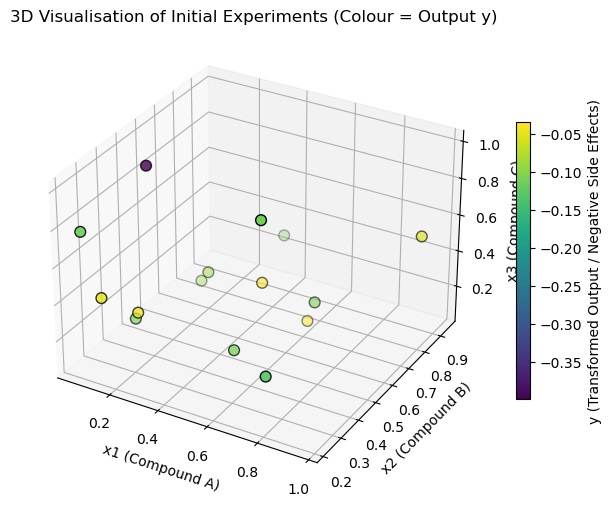

In [7]:
# --- Simple 3D scatter plot ---
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(df_init["x1"], df_init["x2"], df_init["x3"],
                c=df_init["y"], cmap="viridis", s=60, edgecolor='k')

ax.set_xlabel("x1 (Compound A)")
ax.set_ylabel("x2 (Compound B)")
ax.set_zlabel("x3 (Compound C)")
ax.set_title("3D Visualisation of Initial Experiments (Colour = Output y)")

cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label("y (Transformed Output / Negative Side Effects)")

plt.show()